# Пример использования модуля для сопоставления данных, полученных из реанализа CFS2 и данных с метеостанций

In [1]:
import os
import numpy as np
import pandas as pd

from meteotik.reanalysis import CFS2Processor
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 4

Netcdf файл для процессинга слишком большой (более 5 Гб), поэтому в репозиторий в качестве примера он не включен.

In [2]:
rean_processor = CFS2Processor('D:/ura-guba/rean_grid/cfs2', files = ['wind_ura_2019-04-01.nc'])

# Посмотрим какие есть переменные в файле
rean_processor.print_variables()

Variables in netcdf file ['time', 'lon', 'lat', 'height', 'height_2', '10u', '10v', '2t', 'q', 'tmax', 'tmin', 'qmax', 'qmin']


Координаты метеостанции Ура-Губа - 69° 17' с.ш., 32° 48' в.д. Их необходимо перевести в десятичные дроби

In [3]:
from meteotik.analysis import convert_degrees_to_float

lat_coord = convert_degrees_to_float(degrees = 69, minutes = 17, seconds = 0)
lon_coord = convert_degrees_to_float(degrees = 32, minutes = 48, seconds = 0)

# Широта, долгота метеостанции, с которой будет производиться сравнение
print(lat_coord, lon_coord)

69.28333333333333 32.8


Мы можем посмотреть где расположена эта метеостанция.

"Lower left" corner: latitude - -89.84351351786847, longitude - 0.0
"Upper right" corner: latitude - 89.84351351786847, longitude - 359.79545454545456
The scope by latitude - 179.68702703573695
The scope by longitude - 359.79545454545456 



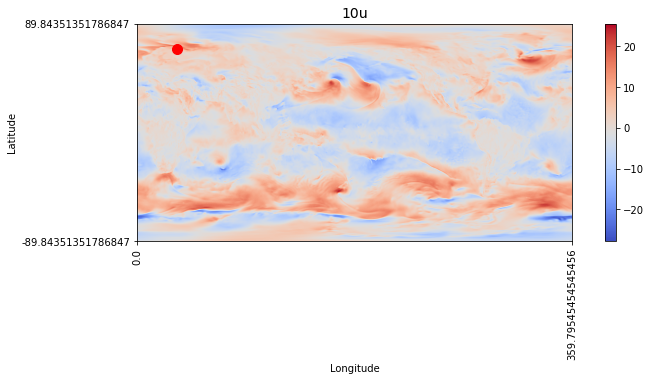

In [4]:
rean_processor.show_spatial_coverage()
rean_processor.field_visualisation(variable = '10u',
                                   coordinates = {'lat': lat_coord, 'lon': lon_coord})

Действительно, всё верно. Заметим, что для реанализа CFS2 нулевая координата долготы - Гринвичский меридиан. 

Составим временной ряд для выбранной точки. Заметим, что дискретность для данного реанализа - 6ти часовая, что не совпадает с данными с метеостанции (наблюдения там фиксировались в другие сроки), поэтому представим данные в часовом масштабе - алгоритм автоматически применит процедуру линейной интерполяции.

Processing... wind_ura_2019-04-01.nc


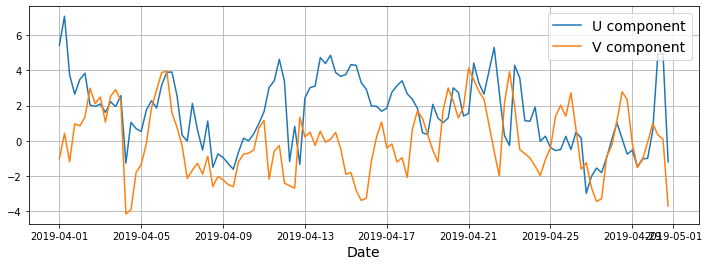

In [5]:
dataframe = rean_processor.prepare_time_series(coordinates = {'lat': lat_coord, 'lon': lon_coord},
                                               change_time_step = True,
                                               new_time_step='1H')
plt.plot(dataframe['Date'], dataframe['U_reanalysis'], label = 'U component')
plt.plot(dataframe['Date'], dataframe['V_reanalysis'], label = 'V component')
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()

## Загрузка данных с метеостанции Rp5

In [6]:
data_ura = pd.read_excel('./data/meteostations/Ura_guba_22018.xls', comment = '#')
data_ura = data_ura[['Местное время в Ура-Губе', 'DD', 'Ff']]
data_ura = data_ura.rename(columns={'Местное время в Ура-Губе': 'Date',
                                    'DD': 'Direction',
                                    'Ff': 'Velocity'})
data_ura['Date'] = pd.to_datetime(data_ura['Date'], format = '%d.%m.%Y %H:%M')
data_ura.dropna(inplace=True)
data_ura.head(3)

,Date,Direction,Velocity
0,2019-04-30 21:00:00,"Ветер, дующий с севера",4
1,2019-04-30 15:00:00,"Ветер, дующий с запада",5
2,2019-04-30 09:00:00,"Ветер, дующий с юго-запада",4


Как видно из фрагмента датафрейма, направление ветра закодировано не в румбах, а имеет словесное описание. Исправим это с помощью метода convert_wind_direction. 

In [7]:
from meteotik.meteo import Rp5Station
import datetime

station_processor = Rp5Station(data_ura)
codes = station_processor.convert_wind_direction('Direction')
data_ura['Direction'] = codes
data_ura.head(3)

,Date,Direction,Velocity
0,2019-04-30 21:00:00,360.0,4
1,2019-04-30 15:00:00,270.0,5
2,2019-04-30 09:00:00,225.0,4


Рассчитаем значения U и V компонент

In [8]:
station_processor = Rp5Station(data_ura)
u_arr, v_arr = station_processor.calculate_uv(vel_col='Velocity',
                                              direction_col='Direction')

data_ura['U_meteo'] = u_arr
data_ura['V_meteo'] = v_arr

Метеостанция расположена в часовом поясе, время в котором отличается от того, которое записано в реанализе (по Гринвичу) - поэтому необходимо "переместить" данные с метеостанции в другой часовой пояс.

Для этого воспользуемся методом time_shift и отнимем (add = False) 3 часа (shift = 3). Для этого укажем колонку date_col, в которой содержится информация о дате/времени. 

In [9]:
data_ura['Date'] = station_processor.time_shift(dataframe = data_ura, 
                                                date_col = 'Date', 
                                                shift = 3, 
                                                add = False)

Приведем датафреймы к единому виду

In [10]:
from meteotik.analysis import equal_mapping

meteo_df, rean_df = equal_mapping(dataframe_left=data_ura, 
                                  dataframe_right=dataframe,
                                  merge_column='Date')

## Сравнение

In [11]:
from meteotik.analysis import print_statistics

print_statistics(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'U_meteo':'U_reanalysis', 
                                        'V_meteo':'V_reanalysis',
                                        'Velocity':'Velocity_reanalysis'})

Bias for U_meteo vs U_reanalysis: -0.57
MAE for U_meteo vs U_reanalysis: 1.17
Pearson correlation coefficient for U_meteo vs U_reanalysis: 0.83


Bias for V_meteo vs V_reanalysis: -0.31
MAE for V_meteo vs V_reanalysis: 1.27
Pearson correlation coefficient for V_meteo vs V_reanalysis: 0.73


Bias for Velocity vs Velocity_reanalysis: -0.59
MAE for Velocity vs Velocity_reanalysis: 1.12
Pearson correlation coefficient for Velocity vs Velocity_reanalysis: 0.73




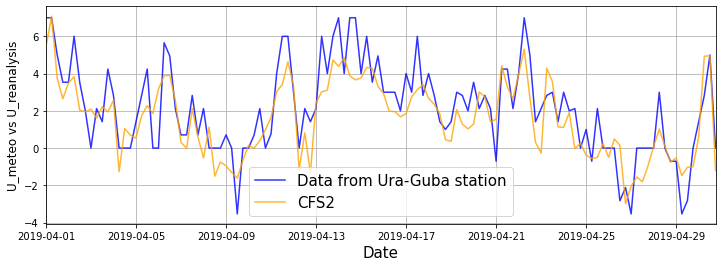

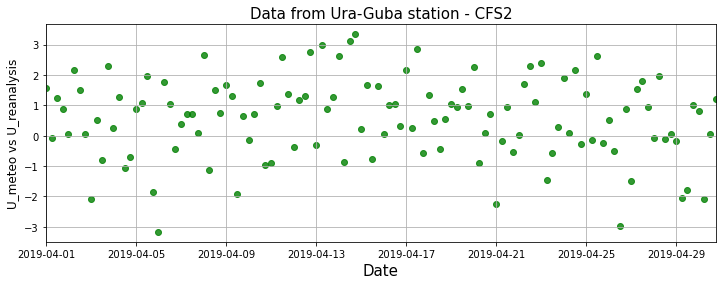

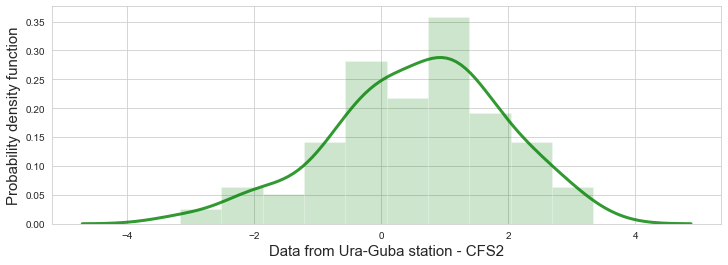

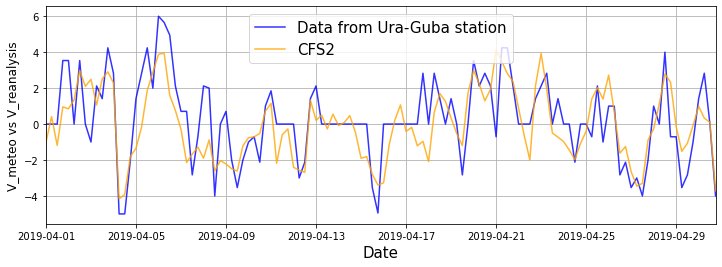

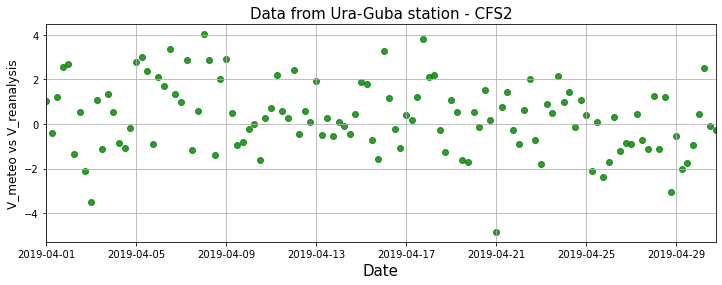

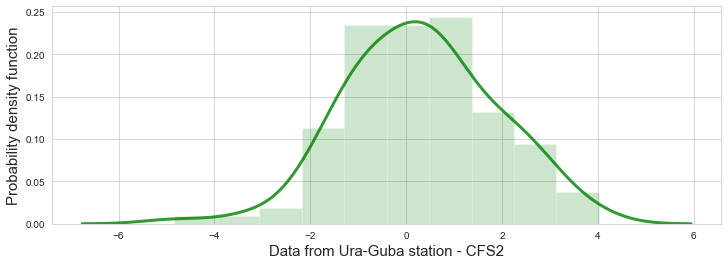

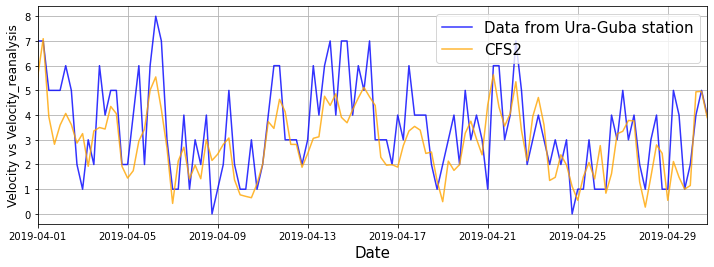

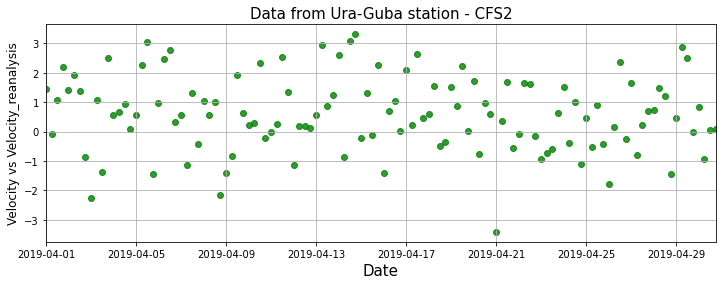

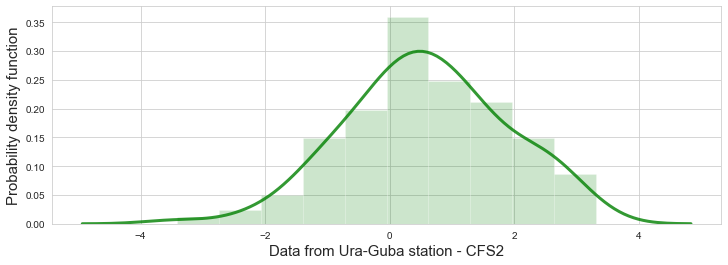

In [12]:
from meteotik.analysis import make_visual_comparison
rcParams['figure.figsize'] = 12, 4

make_visual_comparison(dataframe_left = meteo_df,
                       dataframe_right = rean_df,
                       columns_for_compare = {'U_meteo':'U_reanalysis', 
                                              'V_meteo':'V_reanalysis',
                                              'Velocity':'Velocity_reanalysis'},
                       dataframe_labels = ['Data from Ura-Guba station', 'CFS2'])

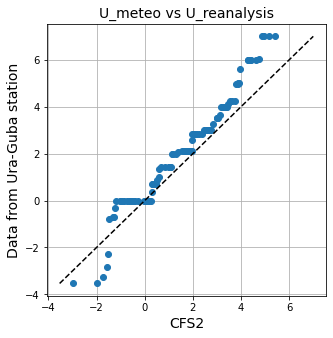

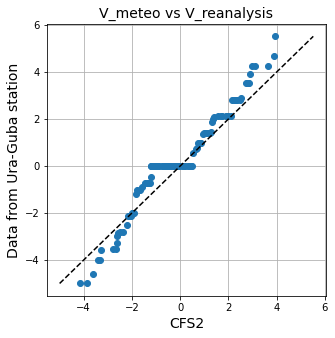

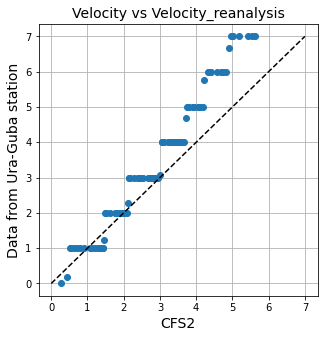

In [13]:
from meteotik.analysis import qq_comparison
rcParams['figure.figsize'] = 5, 5

qq_comparison(dataframe_left = meteo_df,
              dataframe_right = rean_df,
              columns_for_compare = {'U_meteo':'U_reanalysis', 
                                     'V_meteo':'V_reanalysis',
                                     'Velocity':'Velocity_reanalysis'},
              dataframe_labels = ['Data from Ura-Guba station', 'CFS2'])

In [18]:
from meteotik.analysis import make_report

df = make_report(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'U_meteo':'U_reanalysis', 
                                        'V_meteo':'V_reanalysis',
                                        'Velocity':'Velocity_reanalysis'},
                 check_peaks = True)

df

,Variables,Bias,MAE,Correlation
0,U_meteo vs U_reanalysis,-0.568231,1.173935,0.833309
1,(Peak) U_meteo vs U_reanalysis,-1.498230,1.572721,0.548964
2,V_meteo vs V_reanalysis,-0.308162,1.268018,0.730568
3,(Peak) V_meteo vs V_reanalysis,-1.450339,1.654075,0.490512
4,Velocity vs Velocity_reanalysis,-0.594774,1.120571,0.730532
5,(Peak) Velocity vs Velocity_reanalysis,-2.003771,2.012576,0.434288


Таким образом, разработанный модуль "meteotik" позволяет быстро осуществлять следующие операции:
* формировать временные ряды из данных реанализа по указанным координатам;
* менять дискретность временных рядов, полученных с реанализа;
* обрабатывать данные, полученные с метеостанций:
  * объединять отдельные столбцы с датой / временем в один с присвоением datetime формата;
  * переводить словесное описание направлений ветра в румбы;
  * рассчитывать значения U и V компонент из направления и скорости ветра;
  * добавлять/отнимать несколько часов к столбцу с datetime (удобно при учете временных зон);
* производить различные визуализации
* производить расчеты метрик для сравнения метеопараметров